### Import the dependencies

In [745]:
%load_ext lab_black

# Common Imports
import numpy as np
import pandas as pd

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA

# Assessing performance
from sklearn.model_selection import GridSearchCV

# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Making a prediction with the direct multioutput regression model
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

from scipy.stats import norm

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

# To make this notebook's output identical at every run
np.random.seed(42)

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


### Load the data

In [740]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["z", "anchors"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "time",
    "tag",
    "x",
    "y",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1595,1916,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1614,1989,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1620,1971,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1595,1915,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1614,1988,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1315,1863,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1345,1886,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1313,1899,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1315,1861,338.0,603.0,812.0,159.0,599.0


### Visualize the noise

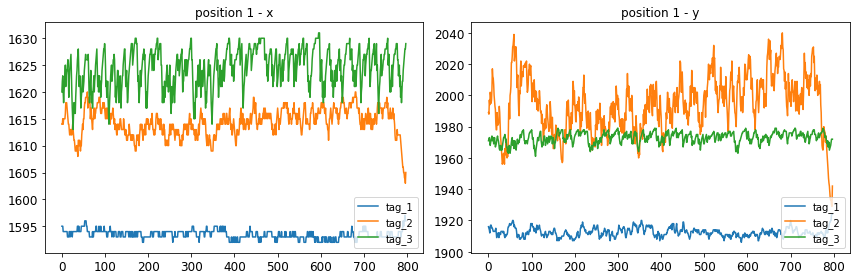

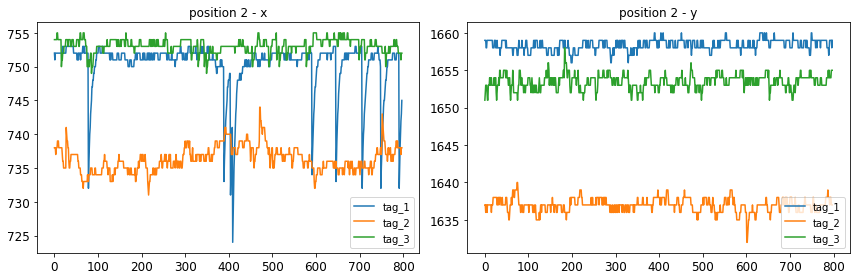

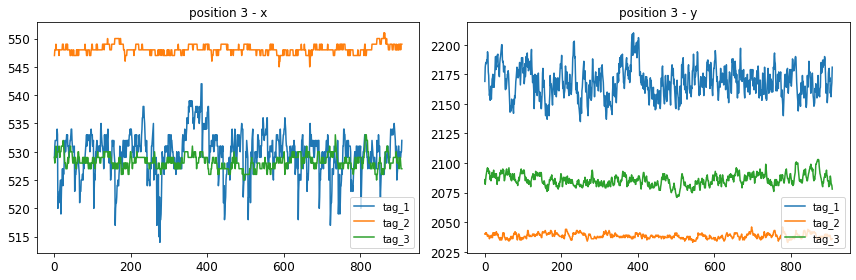

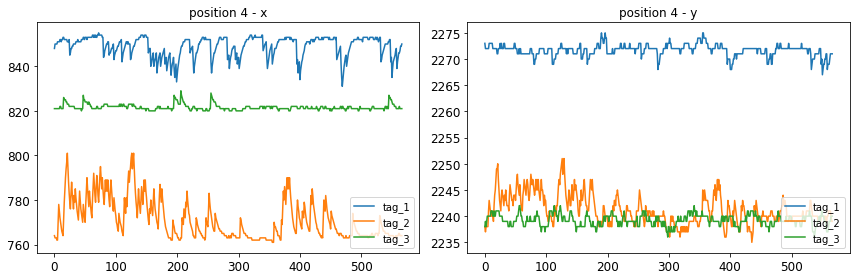

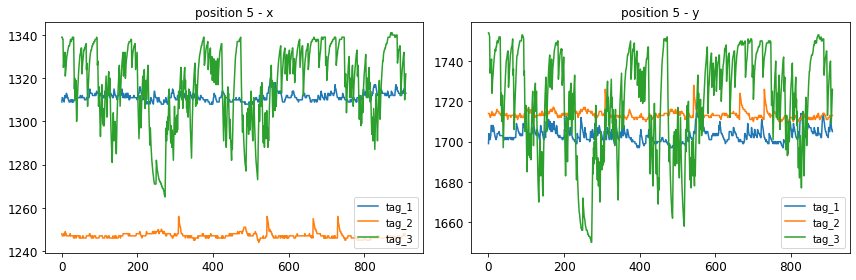

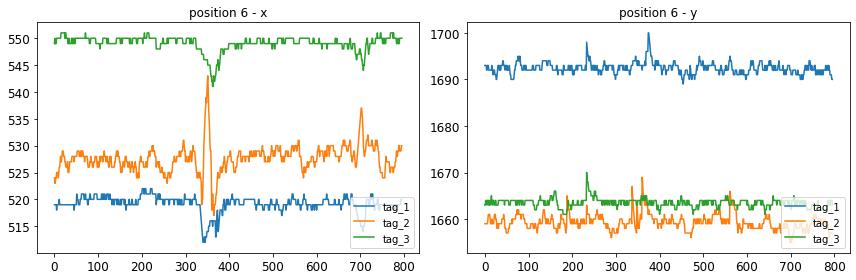

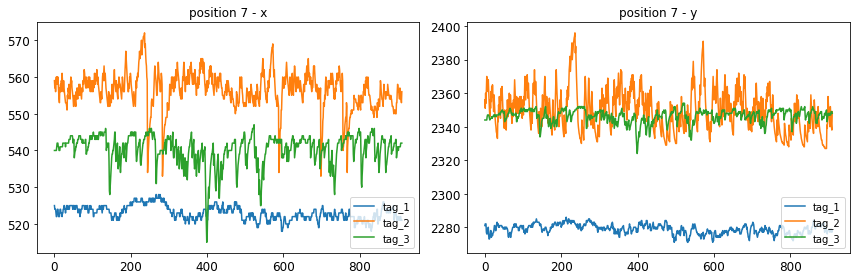

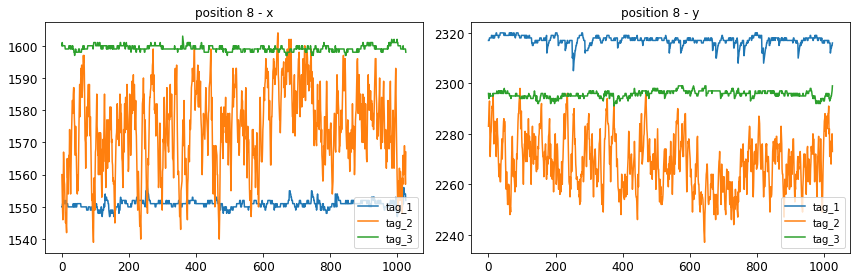

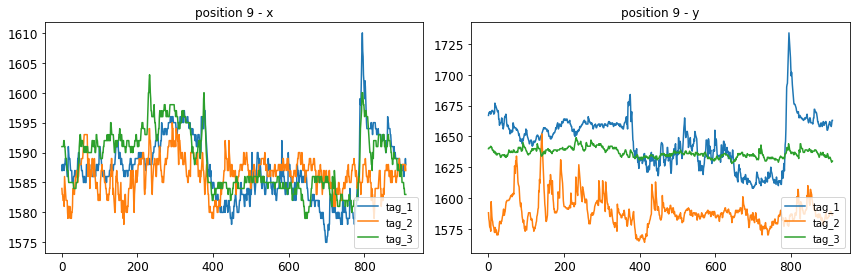

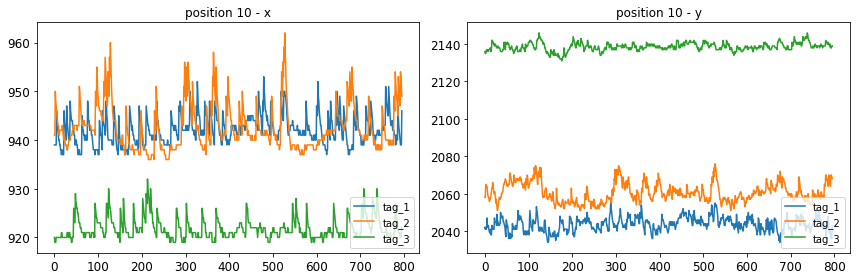

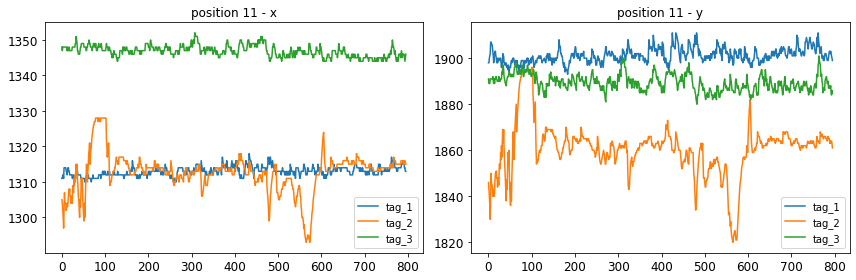

In [741]:
for i in data["position"].unique():
    tag_1_x = data.query(f"position == {i} & tag == 1").x.reset_index(drop=True)
    tag_2_x = data.query(f"position == {i} & tag == 2").x.reset_index(drop=True)
    tag_3_x = data.query(f"position == {i} & tag == 3").x.reset_index(drop=True)

    tag_1_y = data.query(f"position == {i} & tag == 1").y.reset_index(drop=True)
    tag_2_y = data.query(f"position == {i} & tag == 2").y.reset_index(drop=True)
    tag_3_y = data.query(f"position == {i} & tag == 3").y.reset_index(drop=True)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1")
    axes[0].plot(tag_2_x, label="tag_2")
    axes[0].plot(tag_3_x, label="tag_3")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1")
    axes[1].plot(tag_2_y, label="tag_2")
    axes[1].plot(tag_3_y, label="tag_3")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

### Plot the histogram and the PDF for each position

#### x coordinates

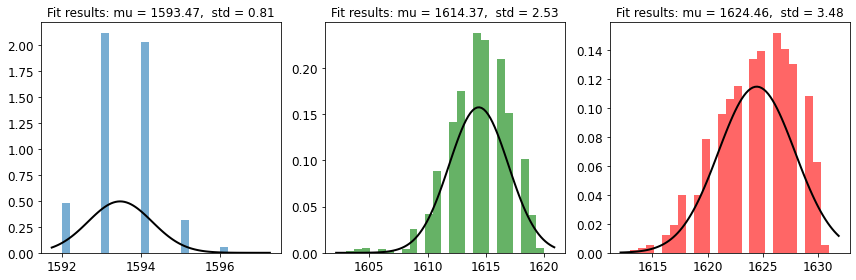

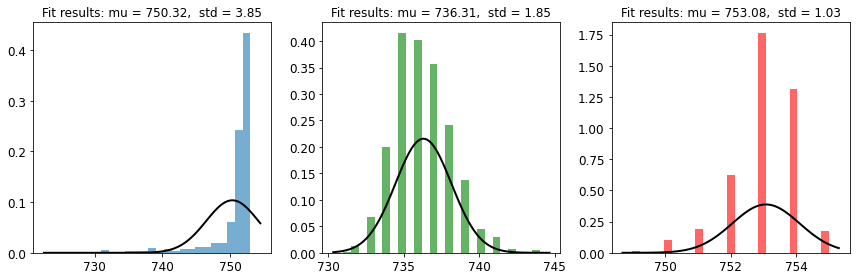

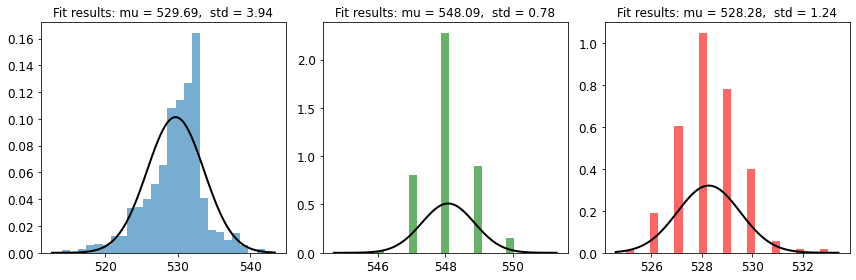

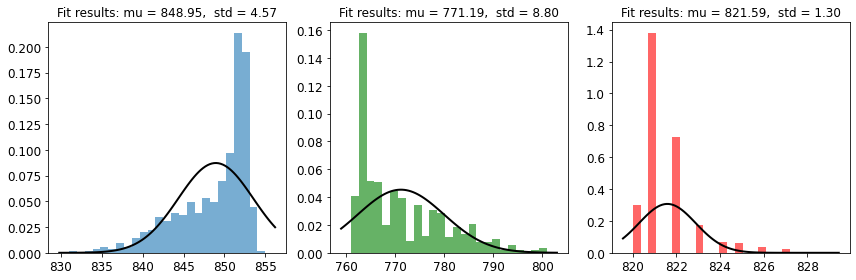

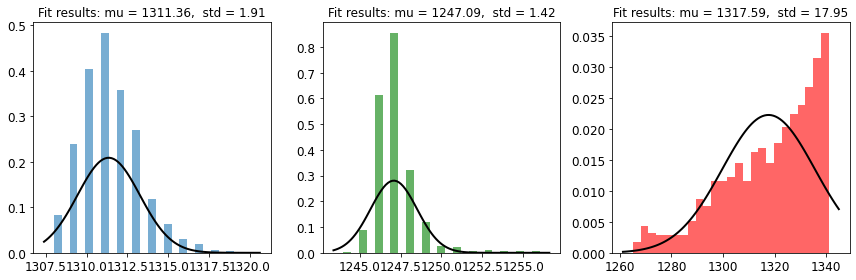

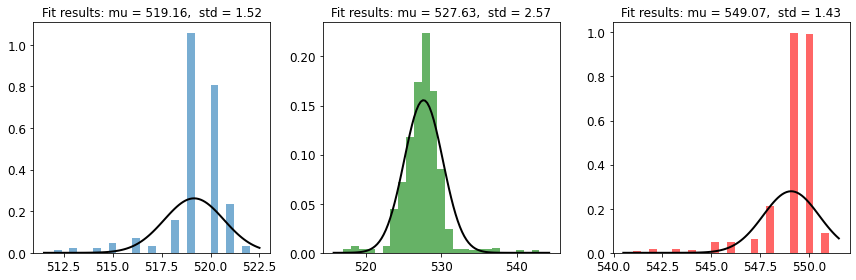

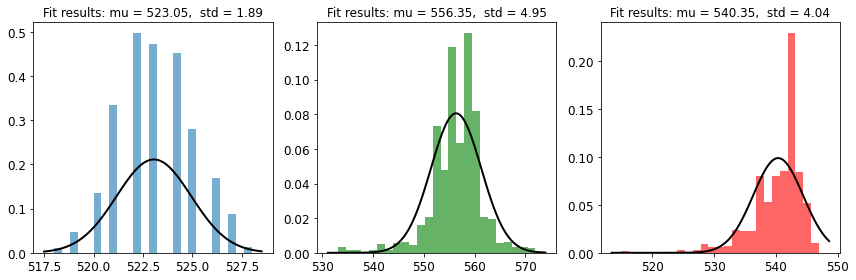

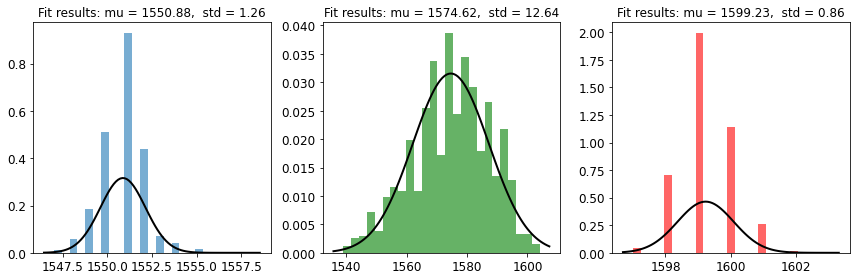

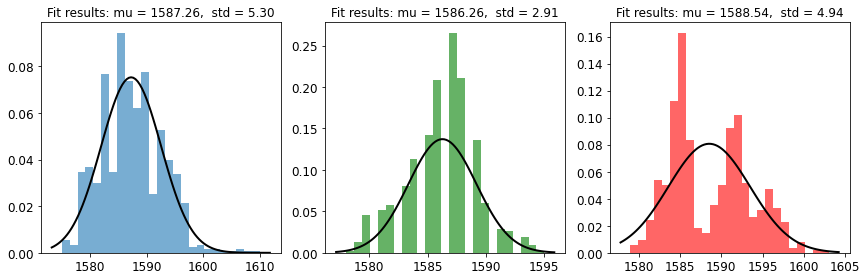

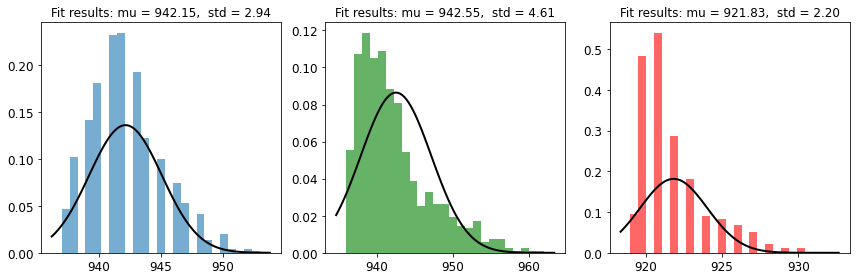

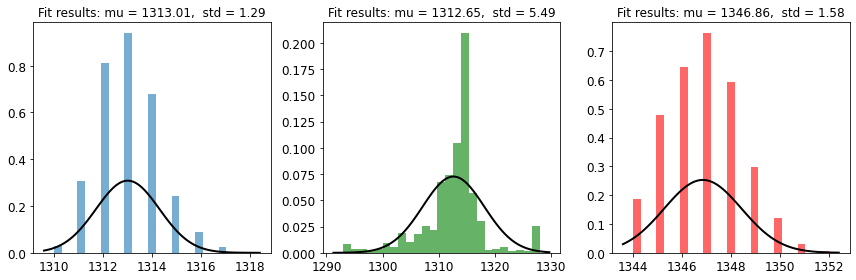

In [742]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").x
    tag_2 = data.query(f"position == {i} & tag == 2").x
    tag_3 = data.query(f"position == {i} & tag == 3").x

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_x.png", bbox_inches="tight")

#### y coordinates

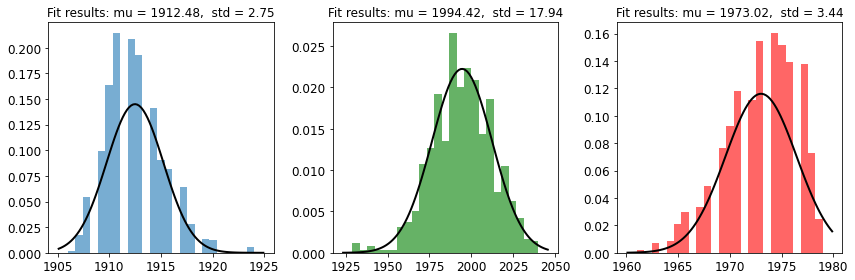

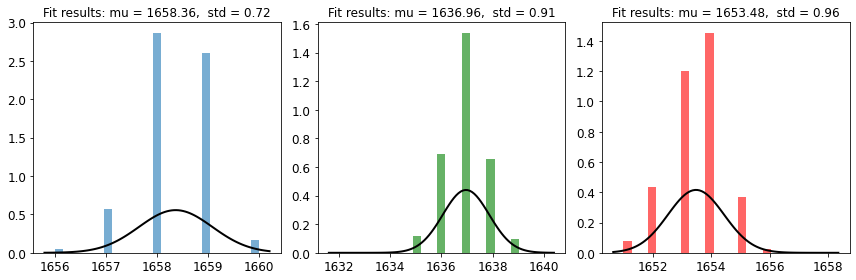

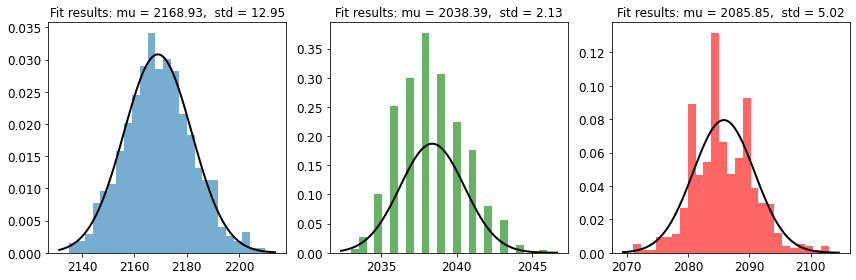

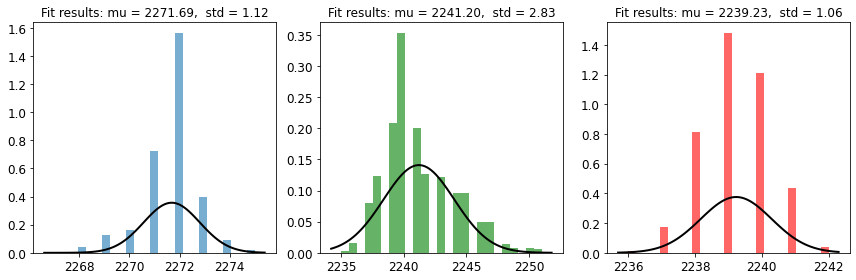

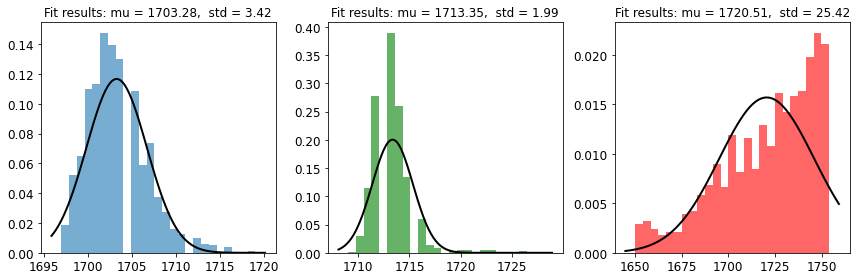

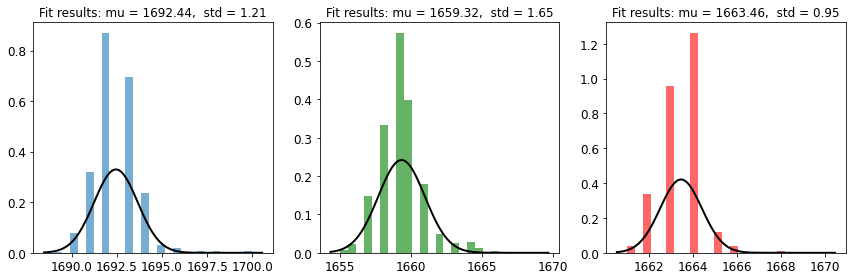

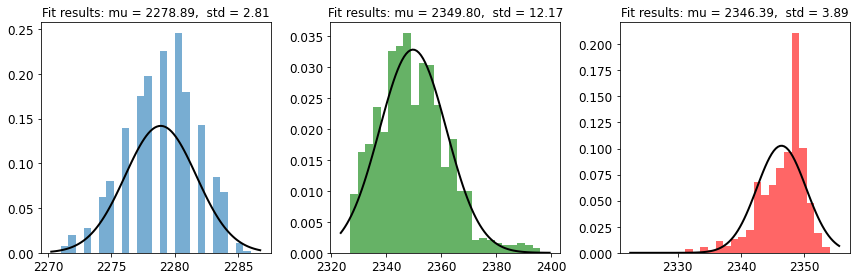

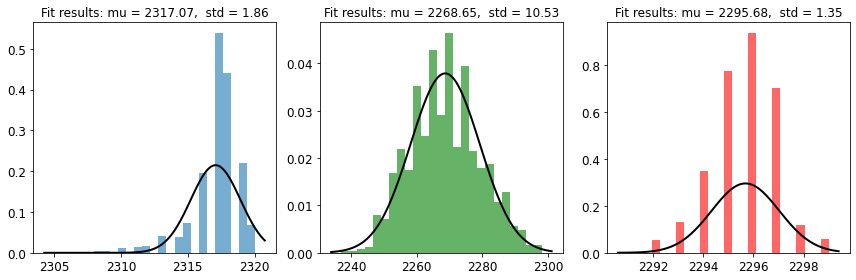

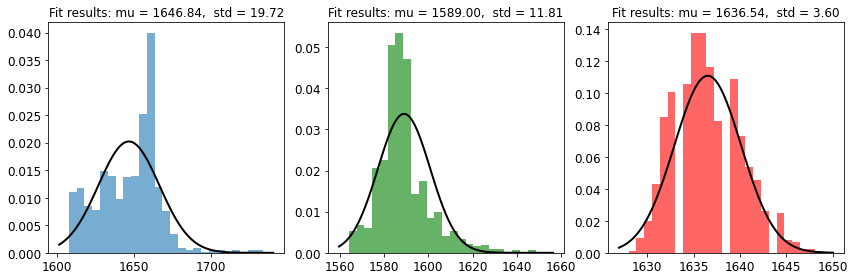

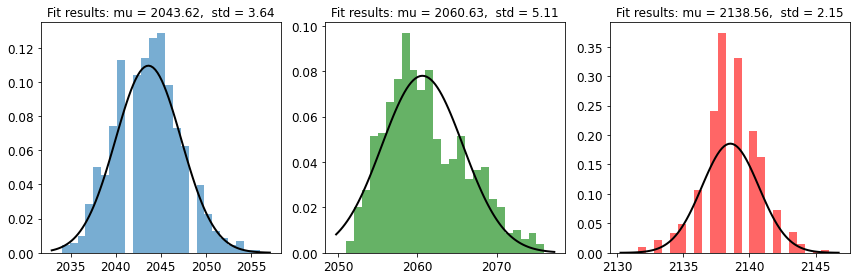

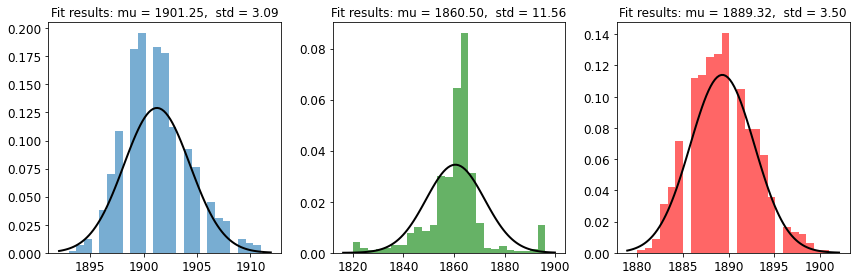

In [743]:
for i in sorted(data["position"].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    tag_1 = data.query(f"position == {i} & tag == 1").y
    tag_2 = data.query(f"position == {i} & tag == 2").y
    tag_3 = data.query(f"position == {i} & tag == 3").y

    # Fit a normal distribution to the data:
    mu_1, std_1 = norm.fit(tag_1)
    mu_2, std_2 = norm.fit(tag_2)
    mu_3, std_3 = norm.fit(tag_3)

    # Plot the histogram.
    axes[0].hist(tag_1, bins=25, density=True, alpha=0.6)
    axes[1].hist(tag_2, bins=25, density=True, alpha=0.6, color="g")
    axes[2].hist(tag_3, bins=25, density=True, alpha=0.6, color="r")

    # Plot the PDF.
    xmin, xmax = axes[0].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_1, std_1)
    axes[0].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_1, std_1)
    axes[0].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[1].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_2, std_2)
    axes[1].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_2, std_2)
    axes[1].title.set_text(title)

    # Plot the PDF.
    xmin, xmax = axes[2].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu_3, std_3)
    axes[2].plot(x, p, "k", linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu_3, std_3)
    axes[2].title.set_text(title)

    fig.tight_layout()
    fig.show()

    fig.savefig(f"graphs/pos_{i}_y.png", bbox_inches="tight")

### Pre-noise removal

Position 1:
Actual: (1597, 1958)
Calc:   (1610, 1959)
Distance: 13.038404810405298
Number of Data Points: 798.0

Position 2:
Actual: (766, 1690)
Calc:   (746, 1649)
Distance: 45.617978911828175
Number of Data Points: 798.0

Position 3:
Actual: (530, 2040)
Calc:   (535, 2097)
Distance: 57.21887800367987
Number of Data Points: 910.0

Position 4:
Actual: (839, 2244)
Calc:   (813, 2250)
Distance: 26.68332812825267
Number of Data Points: 567.0

Position 5:
Actual: (1269, 1744)
Calc:   (1292, 1712)
Distance: 39.408120990476064
Number of Data Points: 911.0

Position 6:
Actual: (530, 1690)
Calc:   (531, 1671)
Distance: 19.026297590440446
Number of Data Points: 796.0

Position 7:
Actual: (530, 2302)
Calc:   (539, 2325)
Distance: 24.698178070456937
Number of Data Points: 911.0

Position 8:
Actual: (1597, 2302)
Calc:   (1574, 2293)
Distance: 24.698178070456937
Number of Data Points: 1026.0

Position 9:
Actual: (1597, 1690)
Calc:   (1587, 1624)
Distance: 66.75327707311455
Number of Data Points: 91

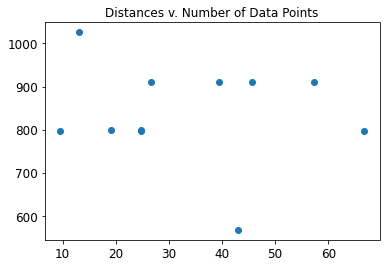

In [744]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

true_pos = zip(x_pos, y_pos)

num_data_points = data["position"].value_counts().div(3).to_dict()
distances = []

for i in sorted(data["position"].unique()):
    tag_1 = data.query(f"position == {i} & tag == 1")
    tag_2 = data.query(f"position == {i} & tag == 2")
    tag_3 = data.query(f"position == {i} & tag == 3")

    x_avg_calc = int((tag_1.x.mean() + tag_2.x.mean() + tag_3.x.mean()) / 3)
    y_avg_calc = int((tag_1.y.mean() + tag_2.y.mean() + tag_3.y.mean()) / 3)

    x_avg_actual, y_avg_actual = next(true_pos)

    distance = (
        ((x_avg_calc - x_avg_actual) ** 2) + ((y_avg_calc - y_avg_actual) ** 2)
    ) ** 0.5

    distances.append(distance)

    print(f"Position {i}:")
    print("Actual:", (x_avg_actual, y_avg_actual))
    print("Calc:  ", (x_avg_calc, y_avg_calc))
    print("Distance:", distance)
    print("Number of Data Points:", num_data_points[i])
    print()

ax = plt.gca()
ax.scatter(distances, num_data_points.values())
ax.title.set_text("Distances v. Number of Data Points")
plt.show()

Increasing the number of data points results in an increase in the noise as well. As such, there seems to be no straight forward relationship between the number of data points and the distance.

### Noise at each position

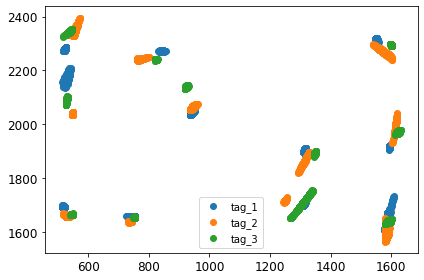

In [214]:
ax = plt.gca()
ax.scatter(data.query("tag == 1").x, data.query("tag == 1").y, label="tag_1")
ax.scatter(data.query("tag == 2").x, data.query("tag == 2").y, label="tag_2")
ax.scatter(data.query("tag == 3").x, data.query("tag == 3").y, label="tag_3")

plt.legend(loc="best")
plt.tight_layout()
plt.show()

### For a given reading, compute the distance from tag 1 to tag 2, tag 2 to tag 3, and tag 1 to tag 3

$d(tag_1,tag_2) = \sqrt{(tag_{2_x} - tag_{1_x})^2 + (tag_{2_y} - tag_{1_y})^2}$

$d(tag_2,tag_3) = \sqrt{(tag_{3_x} - tag_{2_x})^2 + (tag_{3_y} - tag_{2_y})^2}$

$d(tag_1,tag_3) = \sqrt{(tag_{3_x} - tag_{1_x})^2 + (tag_{3_y} - tag_{1_y})^2}$

In [215]:
data_tag_1 = data.query("tag == 1").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_2 = data.query("tag == 2").loc[:, ["x", "y"]].copy().reset_index(drop=True)
data_tag_3 = data.query("tag == 3").loc[:, ["x", "y"]].copy().reset_index(drop=True)

In [216]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

distances = pd.DataFrame(
    data=[AB, BC, AC], index=["tag_1_to_tag_2", "tag_2_to_tag_3", "tag_1_to_tag_3"]
).T

distances

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,75.432089,18.973666,60.415230
1,75.432089,17.888544,63.071388
2,85.375641,25.298221,65.306967
3,84.403791,23.769729,64.474801
4,88.526832,34.132096,57.271284
...,...,...,...
9215,40.000000,39.824616,34.438351
9216,38.052595,35.805028,35.355339
9217,37.054015,34.409301,34.481879
9218,37.054015,37.802116,34.928498


### Drop rows based on standard deviation

In [255]:
true_mean = 21.59
calc_mean_distances = distances.to_numpy().mean()
std_distances = distances.to_numpy().std()

In [256]:
calc_mean_distances, std_distances

(51.965722316201536, 28.96962034612344)

In [169]:
lower_bnd = true_mean - std_distances if lower_bnd > 0 else 0
upper_bnd = true_mean + std_distances

lower_bnd, upper_bnd

(0, 50.55962034612344)

### Four Cases
1. All three are constrained by the bound - keep all (best case)
2. Only two are constrained by the bound
3. Only one is constrained by the bound
4. None of them are constrained by the bound - drop all (worst case)

In [289]:
bounded = (distances >= lower_bnd) & (distances <= upper_bnd)

bounded_all_three = bounded[(bounded.sum(axis=1) == 3)]
bounded_only_two = bounded[(bounded.sum(axis=1) == 2)]
bounded_only_one = ~bounded[(bounded.sum(axis=1) == 1)]
bounded_none = bounded[(bounded.sum(axis=1) == 0)]

In [290]:
bounded_all_three

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
798,True,True,True
799,True,True,True
800,True,True,True
801,True,True,True
802,True,True,True
...,...,...,...
9215,True,True,True
9216,True,True,True
9217,True,True,True
9218,True,True,True


In [291]:
bounded_only_two

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
31,True,True,False
32,True,True,False
33,True,True,False
36,True,True,False
37,True,True,False
...,...,...,...
8958,False,True,True
8959,False,True,True
8974,True,False,True
9009,True,False,True


In [292]:
bounded_only_one

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
0,True,False,True
1,True,False,True
2,True,False,True
3,True,False,True
4,True,False,True
...,...,...,...
9004,True,True,False
9005,True,True,False
9006,True,True,False
9007,True,True,False


In [293]:
bounded_none

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
53,False,False,False
55,False,False,False
56,False,False,False
57,False,False,False
58,False,False,False
...,...,...,...
7518,False,False,False
7519,False,False,False
7520,False,False,False
7521,False,False,False


### Baseline

In [682]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["z", "anchors"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "time",
    "tag",
    "x",
    "y",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1595,1916,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1614,1989,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1620,1971,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1595,1915,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1614,1988,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1315,1863,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1345,1886,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1313,1899,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1315,1861,338.0,603.0,812.0,159.0,599.0


In [683]:
data_tag_1 = data.query("tag == 1").drop(["time", "tag"], axis=1).reset_index(drop=True)
data_tag_2 = data.query("tag == 2").drop(["time", "tag"], axis=1).reset_index(drop=True)
data_tag_3 = data.query("tag == 3").drop(["time", "tag"], axis=1).reset_index(drop=True)

In [684]:
data_tag_1.columns = map("{}_tag_1".format, data_tag_1.columns)
data_tag_2.columns = map("{}_tag_2".format, data_tag_2.columns)
data_tag_3.columns = map("{}_tag_3".format, data_tag_3.columns)

In [685]:
data_pre = (
    data_tag_1.join([data_tag_2, data_tag_3])
    .drop(["position_tag_2", "position_tag_3"], axis=1)
    .rename(columns={"position_tag_1": "position"})
)

data_pre

,position,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
0,1,1595,1916,204.0,871.0,1072.0,375.0,820.0,1614,1989,...,1082.0,468.0,820.0,1620,1971,189.0,882.0,1117.0,401.0,817.0
1,1,1595,1915,205.0,872.0,1072.0,375.0,824.0,1614,1988,...,1082.0,401.0,827.0,1622,1972,188.0,880.0,1116.0,398.0,817.0
2,1,1595,1914,206.0,870.0,1074.0,374.0,822.0,1615,1997,...,1078.0,417.0,819.0,1623,1973,187.0,885.0,1121.0,396.0,817.0
3,1,1594,1912,203.0,872.0,1069.0,373.0,821.0,1614,1994,...,1082.0,421.0,821.0,1620,1971,190.0,890.0,1121.0,396.0,815.0
4,1,1594,1916,199.0,870.0,1070.0,371.0,829.0,1615,2002,...,1082.0,433.0,825.0,1618,1968,188.0,880.0,1120.0,399.0,815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,11,1315,1903,333.0,622.0,801.0,183.0,585.0,1315,1863,...,815.0,157.0,604.0,1346,1888,328.0,636.0,832.0,241.0,624.0
9216,11,1314,1902,333.0,617.0,802.0,184.0,584.0,1316,1864,...,814.0,160.0,598.0,1345,1885,326.0,634.0,833.0,242.0,616.0
9217,11,1314,1901,330.0,621.0,807.0,182.0,581.0,1316,1864,...,812.0,154.0,605.0,1344,1884,327.0,634.0,834.0,240.0,620.0
9218,11,1313,1900,329.0,618.0,802.0,182.0,583.0,1315,1863,...,814.0,160.0,603.0,1345,1886,327.0,636.0,837.0,240.0,615.0


In [686]:
pos_uniq = sorted(data["position"].unique())

x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]
pos_coord = list(zip(x_pos, y_pos))

pos_to_coord = dict((zip(pos_uniq, pos_coord)))

for pos in pos_to_coord.keys():
    x, y = pos_to_coord[pos]
    data_pre.loc[data_pre["position"] == pos, "x"] = x
    data_pre.loc[data_pre["position"] == pos, "y"] = y

data_pre

,position,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,...,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3,x,y
0,1,1595,1916,204.0,871.0,1072.0,375.0,820.0,1614,1989,...,820.0,1620,1971,189.0,882.0,1117.0,401.0,817.0,1597.0,1958.0
1,1,1595,1915,205.0,872.0,1072.0,375.0,824.0,1614,1988,...,827.0,1622,1972,188.0,880.0,1116.0,398.0,817.0,1597.0,1958.0
2,1,1595,1914,206.0,870.0,1074.0,374.0,822.0,1615,1997,...,819.0,1623,1973,187.0,885.0,1121.0,396.0,817.0,1597.0,1958.0
3,1,1594,1912,203.0,872.0,1069.0,373.0,821.0,1614,1994,...,821.0,1620,1971,190.0,890.0,1121.0,396.0,815.0,1597.0,1958.0
4,1,1594,1916,199.0,870.0,1070.0,371.0,829.0,1615,2002,...,825.0,1618,1968,188.0,880.0,1120.0,399.0,815.0,1597.0,1958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,11,1315,1903,333.0,622.0,801.0,183.0,585.0,1315,1863,...,604.0,1346,1888,328.0,636.0,832.0,241.0,624.0,1315.0,1925.0
9216,11,1314,1902,333.0,617.0,802.0,184.0,584.0,1316,1864,...,598.0,1345,1885,326.0,634.0,833.0,242.0,616.0,1315.0,1925.0
9217,11,1314,1901,330.0,621.0,807.0,182.0,581.0,1316,1864,...,605.0,1344,1884,327.0,634.0,834.0,240.0,620.0,1315.0,1925.0
9218,11,1313,1900,329.0,618.0,802.0,182.0,583.0,1315,1863,...,603.0,1345,1886,327.0,636.0,837.0,240.0,615.0,1315.0,1925.0


In [687]:
# take position 1-8 in the test set
X_train = data_pre.query("position < 9").drop(["position", "x", "y"], axis=1)
Y_train = data_pre.query("position < 9")[["x", "y"]].copy()

pos_train = data_pre.query("position < 9")[["position"]]

# display the training set
X_train.join(Y_train)

,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,anchor_1_tag_2,...,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3,x,y
0,1595,1916,204.0,871.0,1072.0,375.0,820.0,1614,1989,209.0,...,820.0,1620,1971,189.0,882.0,1117.0,401.0,817.0,1597.0,1958.0
1,1595,1915,205.0,872.0,1072.0,375.0,824.0,1614,1988,214.0,...,827.0,1622,1972,188.0,880.0,1116.0,398.0,817.0,1597.0,1958.0
2,1595,1914,206.0,870.0,1074.0,374.0,822.0,1615,1997,208.0,...,819.0,1623,1973,187.0,885.0,1121.0,396.0,817.0,1597.0,1958.0
3,1594,1912,203.0,872.0,1069.0,373.0,821.0,1614,1994,211.0,...,821.0,1620,1971,190.0,890.0,1121.0,396.0,815.0,1597.0,1958.0
4,1594,1916,199.0,870.0,1070.0,371.0,829.0,1615,2002,207.0,...,825.0,1618,1968,188.0,880.0,1120.0,399.0,815.0,1597.0,1958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,1554,2314,389.0,995.0,1054.0,702.0,730.0,1569,2268,349.0,...,794.0,1599,2295,377.0,1039.0,1090.0,682.0,789.0,1597.0,2302.0
6713,1554,2314,390.0,991.0,1057.0,764.0,728.0,1562,2275,350.0,...,795.0,1599,2295,374.0,1038.0,1092.0,687.0,785.0,1597.0,2302.0
6714,1554,2315,393.0,990.0,1057.0,764.0,727.0,1561,2277,355.0,...,799.0,1599,2296,376.0,1034.0,1092.0,690.0,787.0,1597.0,2302.0
6715,1554,2315,398.0,992.0,1054.0,763.0,728.0,1557,2280,356.0,...,799.0,1599,2297,378.0,1031.0,1085.0,684.0,790.0,1597.0,2302.0


In [688]:
# take position 9, 10, 11 in the test set
X_test = data_pre.query("position >= 9").drop(["position", "x", "y"], axis=1)
Y_test = data_pre.query("position >= 9")[["x", "y"]].copy()

pos_test = data_pre.query("position >= 9")[["position"]]

# display the test set
X_test.join(Y_test)

,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,anchor_1_tag_2,...,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3,x,y
6717,1587,1667,325.0,867.0,1127.0,306.0,928.0,1584,1588,389.0,...,917.0,1591,1640,361.0,836.0,1136.0,355.0,951.0,1597.0,1690.0
6718,1588,1669,324.0,863.0,1130.0,306.0,932.0,1583,1583,387.0,...,917.0,1591,1640,358.0,833.0,1136.0,351.0,952.0,1597.0,1690.0
6719,1587,1669,324.0,867.0,1127.0,307.0,932.0,1583,1581,413.0,...,917.0,1591,1641,355.0,836.0,1136.0,362.0,952.0,1597.0,1690.0
6720,1588,1670,325.0,869.0,1126.0,306.0,930.0,1582,1577,391.0,...,917.0,1591,1641,358.0,838.0,1138.0,327.0,951.0,1597.0,1690.0
6721,1588,1670,323.0,869.0,1128.0,303.0,932.0,1582,1576,396.0,...,921.0,1591,1641,358.0,840.0,1138.0,354.0,947.0,1597.0,1690.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,1315,1903,333.0,622.0,801.0,183.0,585.0,1315,1863,334.0,...,604.0,1346,1888,328.0,636.0,832.0,241.0,624.0,1315.0,1925.0
9216,1314,1902,333.0,617.0,802.0,184.0,584.0,1316,1864,335.0,...,598.0,1345,1885,326.0,634.0,833.0,242.0,616.0,1315.0,1925.0
9217,1314,1901,330.0,621.0,807.0,182.0,581.0,1316,1864,337.0,...,605.0,1344,1884,327.0,634.0,834.0,240.0,620.0,1315.0,1925.0
9218,1313,1900,329.0,618.0,802.0,182.0,583.0,1315,1863,336.0,...,603.0,1345,1886,327.0,636.0,837.0,240.0,615.0,1315.0,1925.0


In [689]:
# Normalization
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
min_max_scaled_features = min_max_scaler.transform(X_train)

In [690]:
X_train = pd.DataFrame(
    min_max_scaled_features, index=X_train.index, columns=X_train.columns
)
X_train = pos_train.join(X_train)
X_train

,position,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
0,1,0.998157,0.391566,0.005325,0.837327,0.993023,0.019749,0.978428,0.994560,0.467277,...,0.971366,0.138235,0.981873,0.990143,0.455966,0.006104,0.816065,0.992505,0.014337,0.988976
1,1,0.998157,0.390060,0.006390,0.838588,0.993023,0.019749,0.984592,0.994560,0.465969,...,0.971366,0.039706,0.992447,0.991935,0.457386,0.005086,0.813737,0.991435,0.008961,0.988976
2,1,0.998157,0.388554,0.007455,0.836066,0.995349,0.017953,0.981510,0.995467,0.477749,...,0.966960,0.063235,0.980363,0.992832,0.458807,0.004069,0.819558,0.996788,0.005376,0.988976
3,1,0.997235,0.385542,0.004260,0.838588,0.989535,0.016158,0.979969,0.994560,0.473822,...,0.971366,0.069118,0.983384,0.990143,0.455966,0.007121,0.825378,0.996788,0.005376,0.985827
4,1,0.997235,0.391566,0.000000,0.836066,0.990698,0.012567,0.992296,0.995467,0.484293,...,0.971366,0.086765,0.989426,0.988351,0.451705,0.005086,0.813737,0.995717,0.010753,0.985827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,8,0.960369,0.990964,0.202343,0.993695,0.972093,0.606822,0.839753,0.953762,0.832461,...,0.910793,0.352941,0.942598,0.971326,0.916193,0.197355,0.998836,0.963597,0.517921,0.944882
6713,8,0.960369,0.990964,0.203408,0.988651,0.975581,0.718133,0.836672,0.947416,0.841623,...,0.908590,0.344118,0.944109,0.971326,0.916193,0.194303,0.997672,0.965739,0.526882,0.938583
6714,8,0.960369,0.992470,0.206603,0.987390,0.975581,0.718133,0.835131,0.946510,0.844241,...,0.936123,0.347059,0.950151,0.971326,0.917614,0.196338,0.993015,0.965739,0.532258,0.941732
6715,8,0.960369,0.992470,0.211928,0.989912,0.972093,0.716338,0.836672,0.942883,0.848168,...,0.926211,0.347059,0.950151,0.971326,0.919034,0.198372,0.989523,0.958244,0.521505,0.946457


In [691]:
X_train.isnull().sum()

position            0
x_tag_1             0
y_tag_1             0
anchor_1_tag_1      4
anchor_2_tag_1      2
anchor_3_tag_1      6
anchor_4_tag_1    923
anchor_5_tag_1      5
x_tag_2             0
y_tag_2             0
anchor_1_tag_2      5
anchor_2_tag_2      3
anchor_3_tag_2      6
anchor_4_tag_2    921
anchor_5_tag_2      2
x_tag_3             0
y_tag_3             0
anchor_1_tag_3      6
anchor_2_tag_3      5
anchor_3_tag_3      3
anchor_4_tag_3    913
anchor_5_tag_3      3
dtype: int64

In [692]:
for j in range(1, 9):
    # impute the null rows with the mean (fill 0 where this is not possible)
    X_train.loc[X_train["position"] == j] = (
        X_train.query(f"position == {j}")
        .fillna(X_train.query(f"position == {j}").mean())
        .fillna(0)
    )

X_train = X_train.drop("position", axis=1)
X_train

,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,anchor_1_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
0,0.998157,0.391566,0.005325,0.837327,0.993023,0.019749,0.978428,0.994560,0.467277,0.005291,...,0.971366,0.138235,0.981873,0.990143,0.455966,0.006104,0.816065,0.992505,0.014337,0.988976
1,0.998157,0.390060,0.006390,0.838588,0.993023,0.019749,0.984592,0.994560,0.465969,0.010582,...,0.971366,0.039706,0.992447,0.991935,0.457386,0.005086,0.813737,0.991435,0.008961,0.988976
2,0.998157,0.388554,0.007455,0.836066,0.995349,0.017953,0.981510,0.995467,0.477749,0.004233,...,0.966960,0.063235,0.980363,0.992832,0.458807,0.004069,0.819558,0.996788,0.005376,0.988976
3,0.997235,0.385542,0.004260,0.838588,0.989535,0.016158,0.979969,0.994560,0.473822,0.007407,...,0.971366,0.069118,0.983384,0.990143,0.455966,0.007121,0.825378,0.996788,0.005376,0.985827
4,0.997235,0.391566,0.000000,0.836066,0.990698,0.012567,0.992296,0.995467,0.484293,0.003175,...,0.971366,0.086765,0.989426,0.988351,0.451705,0.005086,0.813737,0.995717,0.010753,0.985827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6712,0.960369,0.990964,0.202343,0.993695,0.972093,0.606822,0.839753,0.953762,0.832461,0.153439,...,0.910793,0.352941,0.942598,0.971326,0.916193,0.197355,0.998836,0.963597,0.517921,0.944882
6713,0.960369,0.990964,0.203408,0.988651,0.975581,0.718133,0.836672,0.947416,0.841623,0.154497,...,0.908590,0.344118,0.944109,0.971326,0.916193,0.194303,0.997672,0.965739,0.526882,0.938583
6714,0.960369,0.992470,0.206603,0.987390,0.975581,0.718133,0.835131,0.946510,0.844241,0.159788,...,0.936123,0.347059,0.950151,0.971326,0.917614,0.196338,0.993015,0.965739,0.532258,0.941732
6715,0.960369,0.992470,0.211928,0.989912,0.972093,0.716338,0.836672,0.942883,0.848168,0.160847,...,0.926211,0.347059,0.950151,0.971326,0.919034,0.198372,0.989523,0.958244,0.521505,0.946457


In [693]:
X_train.isnull().sum()

x_tag_1           0
y_tag_1           0
anchor_1_tag_1    0
anchor_2_tag_1    0
anchor_3_tag_1    0
anchor_4_tag_1    0
anchor_5_tag_1    0
x_tag_2           0
y_tag_2           0
anchor_1_tag_2    0
anchor_2_tag_2    0
anchor_3_tag_2    0
anchor_4_tag_2    0
anchor_5_tag_2    0
x_tag_3           0
y_tag_3           0
anchor_1_tag_3    0
anchor_2_tag_3    0
anchor_3_tag_3    0
anchor_4_tag_3    0
anchor_5_tag_3    0
dtype: int64

In [694]:
min_max_scaled_features = min_max_scaler.transform(X_test)

X_test = pd.DataFrame(
    min_max_scaled_features, index=X_test.index, columns=X_test.columns
)

X_test = pos_test.join(X_test)
X_test

,position,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
6717,9,0.990783,0.016566,0.134185,0.832282,1.056977,-0.104129,1.144838,0.967362,-0.057592,...,1.048458,-0.129412,1.128399,0.964158,-0.014205,0.181078,0.762515,1.012848,-0.068100,1.200000
6718,9,0.991705,0.019578,0.133120,0.827238,1.060465,-0.104129,1.151002,0.966455,-0.064136,...,1.050661,-0.135294,1.128399,0.964158,-0.014205,0.178026,0.759022,1.012848,-0.075269,1.201575
6719,9,0.990783,0.019578,0.133120,0.832282,1.056977,-0.102334,1.151002,0.966455,-0.066754,...,1.047357,-0.132353,1.128399,0.964158,-0.012784,0.174975,0.762515,1.012848,-0.055556,1.201575
6720,9,0.991705,0.021084,0.134185,0.834805,1.055814,-0.104129,1.147920,0.965549,-0.071990,...,1.049559,-0.135294,1.128399,0.964158,-0.012784,0.178026,0.764843,1.014989,-0.118280,1.200000
6721,9,0.991705,0.021084,0.132055,0.834805,1.058140,-0.109515,1.151002,0.965549,-0.073298,...,1.048458,-0.130882,1.134441,0.964158,-0.012784,0.178026,0.767171,1.014989,-0.069892,1.193701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,11,0.740092,0.371988,0.142705,0.523329,0.677907,-0.324955,0.616333,0.723481,0.302356,...,0.677313,-0.319118,0.655589,0.744624,0.338068,0.147508,0.529686,0.687366,-0.272401,0.685039
9216,11,0.739171,0.370482,0.142705,0.517024,0.679070,-0.323160,0.614792,0.724388,0.303665,...,0.676211,-0.314706,0.646526,0.743728,0.333807,0.145473,0.527357,0.688437,-0.270609,0.672441
9217,11,0.739171,0.368976,0.139510,0.522068,0.684884,-0.326750,0.610169,0.724388,0.303665,...,0.674009,-0.323529,0.657100,0.742832,0.332386,0.146490,0.527357,0.689507,-0.274194,0.678740
9218,11,0.738249,0.367470,0.138445,0.518285,0.679070,-0.326750,0.613251,0.723481,0.302356,...,0.676211,-0.314706,0.654079,0.743728,0.335227,0.146490,0.529686,0.692719,-0.274194,0.670866


In [695]:
X_test.isnull().sum()

position          0
x_tag_1           0
y_tag_1           0
anchor_1_tag_1    0
anchor_2_tag_1    0
anchor_3_tag_1    3
anchor_4_tag_1    7
anchor_5_tag_1    0
x_tag_2           0
y_tag_2           0
anchor_1_tag_2    0
anchor_2_tag_2    0
anchor_3_tag_2    4
anchor_4_tag_2    2
anchor_5_tag_2    1
x_tag_3           0
y_tag_3           0
anchor_1_tag_3    2
anchor_2_tag_3    0
anchor_3_tag_3    2
anchor_4_tag_3    1
anchor_5_tag_3    0
dtype: int64

In [696]:
for j in range(9, 12):
    # impute the null rows with the mean (fill 0 where this is not possible)
    X_test.loc[X_test["position"] == j] = (
        X_test.query(f"position == {j}")
        .fillna(X_test.query(f"position == {j}").mean())
        .fillna(0)
    )

X_test = X_test.drop("position", axis=1)
X_test

,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,y_tag_2,anchor_1_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
6717,0.990783,0.016566,0.134185,0.832282,1.056977,-0.104129,1.144838,0.967362,-0.057592,0.195767,...,1.048458,-0.129412,1.128399,0.964158,-0.014205,0.181078,0.762515,1.012848,-0.068100,1.200000
6718,0.991705,0.019578,0.133120,0.827238,1.060465,-0.104129,1.151002,0.966455,-0.064136,0.193651,...,1.050661,-0.135294,1.128399,0.964158,-0.014205,0.178026,0.759022,1.012848,-0.075269,1.201575
6719,0.990783,0.019578,0.133120,0.832282,1.056977,-0.102334,1.151002,0.966455,-0.066754,0.221164,...,1.047357,-0.132353,1.128399,0.964158,-0.012784,0.174975,0.762515,1.012848,-0.055556,1.201575
6720,0.991705,0.021084,0.134185,0.834805,1.055814,-0.104129,1.147920,0.965549,-0.071990,0.197884,...,1.049559,-0.135294,1.128399,0.964158,-0.012784,0.178026,0.764843,1.014989,-0.118280,1.200000
6721,0.991705,0.021084,0.132055,0.834805,1.058140,-0.109515,1.151002,0.965549,-0.073298,0.203175,...,1.048458,-0.130882,1.134441,0.964158,-0.012784,0.178026,0.767171,1.014989,-0.069892,1.193701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9215,0.740092,0.371988,0.142705,0.523329,0.677907,-0.324955,0.616333,0.723481,0.302356,0.137566,...,0.677313,-0.319118,0.655589,0.744624,0.338068,0.147508,0.529686,0.687366,-0.272401,0.685039
9216,0.739171,0.370482,0.142705,0.517024,0.679070,-0.323160,0.614792,0.724388,0.303665,0.138624,...,0.676211,-0.314706,0.646526,0.743728,0.333807,0.145473,0.527357,0.688437,-0.270609,0.672441
9217,0.739171,0.368976,0.139510,0.522068,0.684884,-0.326750,0.610169,0.724388,0.303665,0.140741,...,0.674009,-0.323529,0.657100,0.742832,0.332386,0.146490,0.527357,0.689507,-0.274194,0.678740
9218,0.738249,0.367470,0.138445,0.518285,0.679070,-0.326750,0.613251,0.723481,0.302356,0.139683,...,0.676211,-0.314706,0.654079,0.743728,0.335227,0.146490,0.529686,0.692719,-0.274194,0.670866


In [737]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .query("tag == 1")
    .loc[:, ["marker", "x", "y"]]
    .reset_index(drop=True)
)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = ["position", "x", "y"]

data

,position,x,y
0,1,1595,1916
1,1,1595,1915
2,1,1595,1914
3,1,1594,1912
4,1,1594,1916
...,...,...,...
9215,11,1315,1903
9216,11,1314,1902
9217,11,1314,1901
9218,11,1313,1900


In [731]:
df = data.query("position == 1").drop("position", axis=1)

df.index = df.index + 1
df_out = df.stack()
df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
df_out = df_out.to_frame().T

df_out

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_2390,y_2390,x_2391,y_2391,x_2392,y_2392,x_2393,y_2393,x_2394,y_2394
0,1595,1916,1614,1989,1620,1971,1595,1915,1614,1988,...,1603,1929,1628,1972,1596,1924,1605,1942,1629,1972


In [738]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

for i in sorted(data["position"].astype(int).unique()):

    #####################################################################
    # X_train - train on 10/11
    #####################################################################

    # leave one position out
    training_data = data.query(f"position != {i}").reset_index(drop=True)
    position = training_data[["position"]].copy()
    X_train = training_data.drop("position", axis=1)

    # normalize the 10 positions
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    scaled_train_features = min_max_scaler.transform(X_train)

    # convert the normalized matrix to a dataframe
    X_train = pd.DataFrame(
        scaled_train_features, index=X_train.index, columns=X_train.columns
    )

    # add the position each row corresponds to
    X_train = position.join(X_train)

    X_train_transposed = pd.DataFrame()

    for j in X_train["position"].unique():

        # impute the null rows with the mean (fill 0 where this is not possible)
        X_train.loc[X_train["position"] == j] = (
            X_train.query(f"position == {j}")
            .fillna(X_train.query(f"position == {j}").mean())
            .fillna(0)
        )

        # stack the position data into a single row
        df = (
            X_train.query(f"position == {j}")
            .copy(deep=True)
            .drop("position", axis=1)
            .reset_index(drop=True)
        )

        df.index = df.index + 1
        df_out = df.stack()
        df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
        df_out = df_out.to_frame().T

        # compose everything in a single dateframe
        X_train_transposed = (
            X_train_transposed.append(df_out).fillna(0).reset_index(drop=True)
        )

    # match each row with its corresponding position in the Y_train
    x = x_pos.copy()
    y = y_pos.copy()

    x_test_pos = x.pop(i - 1)
    y_test_pos = y.pop(i - 1)

    Y_train = pd.DataFrame()
    Y_train["x"] = x
    Y_train["y"] = y

    ####################################################################
    # X_test - test on 1/11
    ####################################################################

    testing_set = data.query(f"position == {i}").reset_index(drop=True)
    position = testing_set[["position"]].copy()

    X_test = testing_set.drop("position", axis=1)

    scaled_test_features = min_max_scaler.transform(X_test)

    X_test = pd.DataFrame(
        scaled_test_features, index=X_test.index, columns=X_test.columns
    )

    X_test = position.join(X_test)

    X_test.loc[X_test["position"] == i] = (
        X_test.query(f"position == {i}")
        .fillna(X_test.query(f"position == {i}").mean())
        .fillna(0)
    )

    df = X_test.drop("position", axis=1).reset_index(drop=True)

    df.index = df.index + 1
    df_out = df.stack()
    df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
    X_test_transposed = df_out.to_frame().T

    if X_train_transposed.shape[1] >= X_test_transposed.shape[1]:
        X_test_transposed = (
            X_train_transposed.append(X_test_transposed).fillna(0).tail(1)
        )
    else:
        X_train_transposed = (
            X_test_transposed.append(X_train_transposed).fillna(0).tail(10)
        )

    Y_test = pd.DataFrame()
    Y_test["x"] = [x_test_pos]
    Y_test["y"] = [y_test_pos]

    #####################################################################
    # PCA
    #####################################################################

    #     pca = PCA()
    #     pca.fit(X_train_transposed)

    #     X_train = pca.transform(X_train_transposed)
    #     X_test = pca.transform(X_test_transposed)

    X_train = X_train_transposed
    X_test = X_test_transposed

    #     print("Shape of X_train:", X_train.shape)
    #     print("Shape of X_test: ", X_test.shape)

    #####################################################################
    # Train a non-linear SVM
    #####################################################################

    model = SVR()
    wrapper = MultiOutputRegressor(model)
    wrapper.fit(X_train, Y_train)

    yhat = wrapper.predict(X_test)

    print("Actual:", Y_test.to_numpy()[0])
    print("Predicted:", yhat[0].tolist())
    print("-" * 50)

Actual: [1597 1958]
Predicted: [894.0547582518667, 1980.6705116192397]
--------------------------------------------------
Actual: [ 766 1690]
Predicted: [1105.225252707362, 1997.9260497730993]
--------------------------------------------------
Actual: [ 530 2040]
Predicted: [1104.1031066245523, 1943.3690405726509]
--------------------------------------------------
Actual: [ 839 2244]
Predicted: [1104.8199358295149, 1942.7056745832929]
--------------------------------------------------
Actual: [1269 1744]
Predicted: [893.7084527493146, 1996.752495036852]
--------------------------------------------------
Actual: [ 530 1690]
Predicted: [1104.7580283920647, 1998.5376847847888]
--------------------------------------------------
Actual: [ 530 2302]
Predicted: [1104.551538661858, 1943.391070478101]
--------------------------------------------------
Actual: [1597 2302]
Predicted: [892.0057884535125, 1942.1463506475636]
--------------------------------------------------
Actual: [1597 1690]
Pre

In [735]:
X_train_transposed

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_3074,y_3074,x_3075,y_3075,x_3076,y_3076,x_3077,y_3077,x_3078,y_3078
0,0.218579,0.114183,0.205829,0.087740,0.220401,0.104567,0.217668,0.114183,0.205829,0.087740,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.015483,0.727163,0.031876,0.572115,0.015483,0.627404,0.017304,0.741587,0.032787,0.572115,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.306011,0.852163,0.229508,0.810096,0.281421,0.810096,0.307832,0.850962,0.228597,0.808894,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.725865,0.162260,0.670310,0.180288,0.753188,0.228365,0.727687,0.168269,0.669399,0.180288,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.006375,0.155048,0.010929,0.114183,0.033698,0.118990,0.006375,0.155048,0.010018,0.114183,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.011840,0.861779,0.042805,0.951923,0.025501,0.937500,0.010929,0.862981,0.040984,0.945913,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.945355,0.905048,0.954463,0.864183,0.990893,0.879808,0.945355,0.905048,0.948998,0.868990,...,0.95173,0.860577,0.989982,0.88101,0.947177,0.903846,0.960838,0.852163,0.989071,0.883413
7,0.979053,0.123798,0.976321,0.028846,0.982696,0.091346,0.979964,0.126202,0.975410,0.022837,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.388889,0.574519,0.390710,0.593750,0.371585,0.687500,0.388889,0.573317,0.390710,0.593750,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.727687,0.401442,0.722222,0.338942,0.761384,0.393029,0.727687,0.401442,0.721311,0.335337,...,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [704]:
model = SVR()
wrapper = MultiOutputRegressor(model)
wrapper.fit(X_train, Y_train)

yhat = wrapper.predict(X_test.iloc[:1].to_numpy())

# print("Actual:", )
print("Predicted:", yhat)
print("-" * 50)

MultiOutputRegressor(estimator=SVR())

In [706]:
yhat = wrapper.predict(X_test.iloc[:1].to_numpy())

# print("Actual:", )
print("Predicted:", yhat)
print("-" * 50)

Predicted: [[1365.92472164 1857.19293238]]
--------------------------------------------------


In [560]:
data_pre = data_pre.drop(bounded_none.index)

8     1021
7      905
9      894
2      798
6      796
11     796
10     796
1      756
5      742
4      567
3      374
Name: position, dtype: int64

In [534]:
bounded_only_two

,tag_1_to_tag_2,tag_2_to_tag_3,tag_1_to_tag_3
31,True,True,False
32,True,True,False
33,True,True,False
36,True,True,False
37,True,True,False
...,...,...,...
8958,False,True,True
8959,False,True,True
8974,True,False,True
9009,True,False,True


In [533]:
data_pre.loc[bounded_only_two.index]

,position,time,x_tag_1,y_tag_1,anchor_1_tag_1,anchor_2_tag_1,anchor_3_tag_1,anchor_4_tag_1,anchor_5_tag_1,x_tag_2,...,anchor_3_tag_2,anchor_4_tag_2,anchor_5_tag_2,x_tag_3,y_tag_3,anchor_1_tag_3,anchor_2_tag_3,anchor_3_tag_3,anchor_4_tag_3,anchor_5_tag_3
31,1,42:25.7,1594,1913,206.0,874.0,1074.0,375.0,822.0,1609,...,1080.0,453.0,831.0,1616,1965,188.0,885.0,1116.0,396.0,819.0
32,1,42:25.7,1594,1913,204.0,873.0,1075.0,375.0,823.0,1609,...,1083.0,465.0,831.0,1619,1967,186.0,882.0,1116.0,396.0,817.0
33,1,42:25.7,1594,1913,202.0,869.0,1076.0,375.0,820.0,1609,...,1081.0,516.0,825.0,1621,1969,185.0,880.0,1117.0,400.0,817.0
36,1,42:25.9,1595,1912,203.0,872.0,1074.0,378.0,820.0,1609,...,1082.0,480.0,819.0,1626,1973,186.0,882.0,1113.0,398.0,818.0
37,1,42:25.9,1595,1910,207.0,872.0,1069.0,376.0,818.0,1608,...,1081.0,467.0,824.0,1627,1974,186.0,886.0,1112.0,396.0,815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958,11,11:18.5,1313,1905,332.0,618.0,810.0,178.0,583.0,1308,...,816.0,156.0,605.0,1345,1883,328.0,635.0,837.0,244.0,621.0
8959,11,11:18.5,1312,1903,335.0,618.0,804.0,186.0,585.0,1308,...,815.0,157.0,608.0,1346,1883,330.0,637.0,835.0,241.0,621.0
8974,11,11:19.2,1311,1902,336.0,618.0,800.0,179.0,580.0,1308,...,810.0,161.0,598.0,1348,1888,325.0,637.0,833.0,237.0,620.0
9009,11,11:20.7,1312,1899,338.0,619.0,802.0,183.0,584.0,1309,...,816.0,157.0,602.0,1346,1887,328.0,638.0,835.0,241.0,621.0


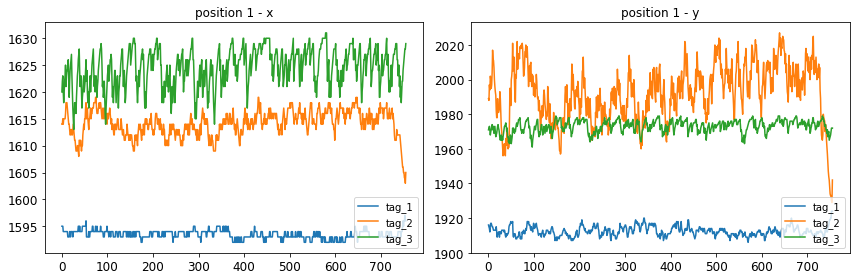

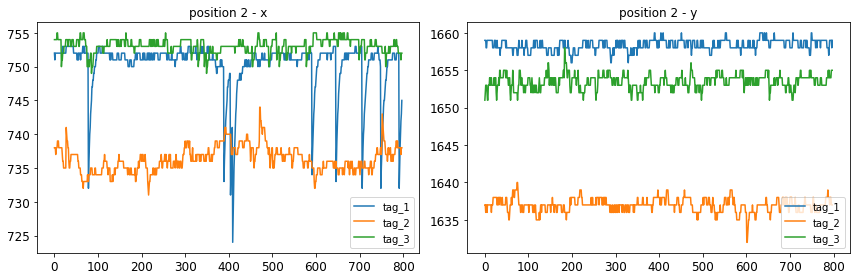

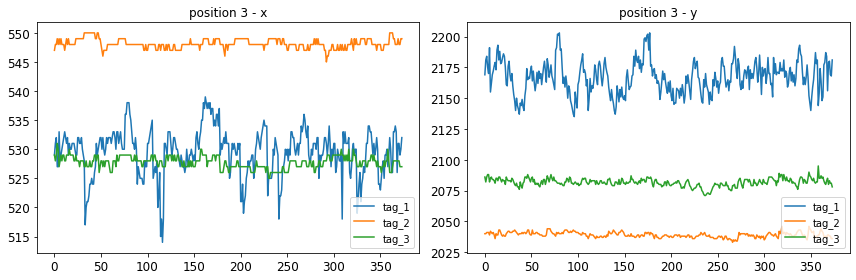

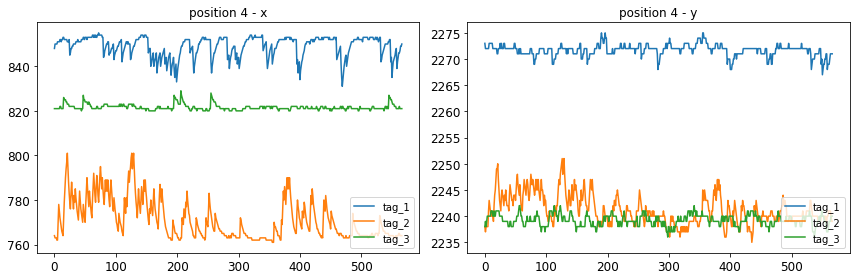

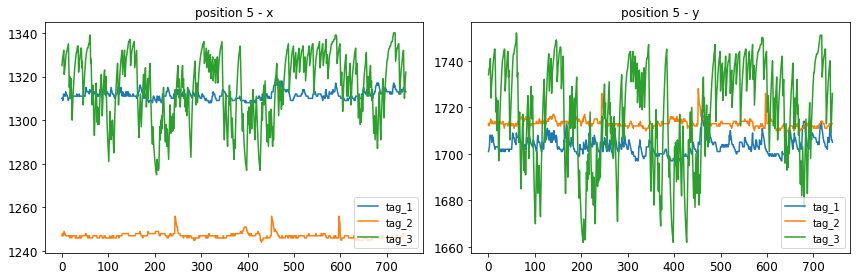

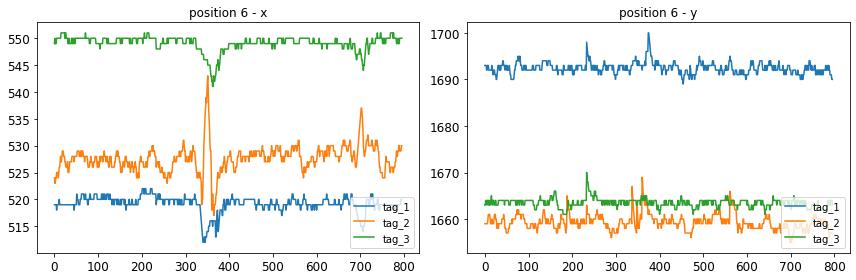

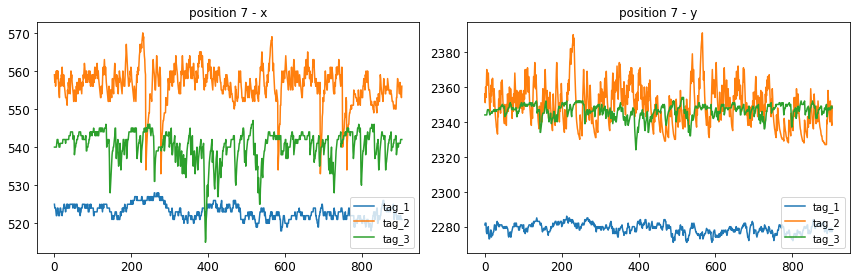

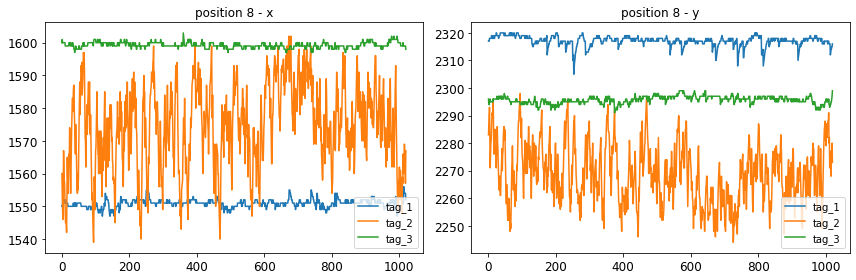

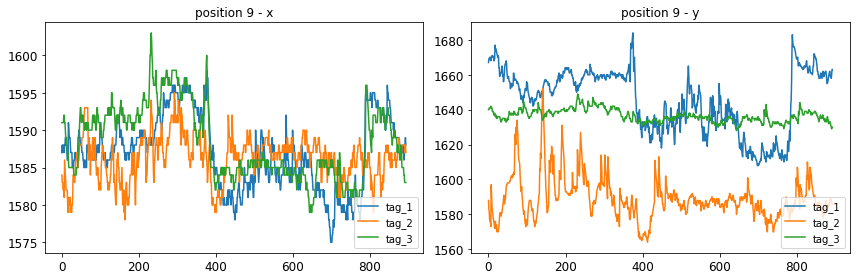

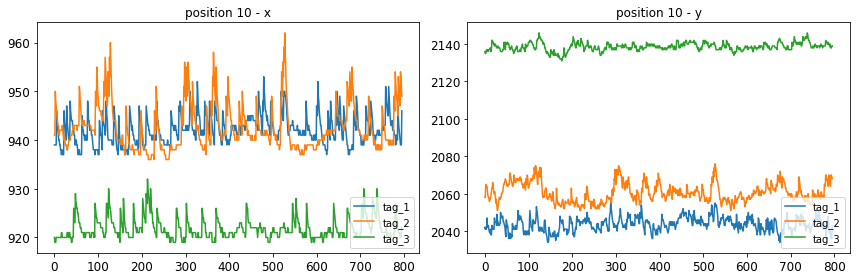

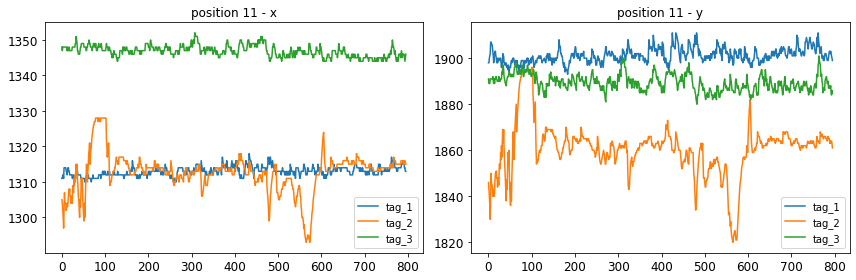

In [524]:
for i in data_pre["position"].unique():

    tag_1_x = (
        data_pre.query(f"position == {i}").loc[:, "x_tag_1"].reset_index(drop=True)
    )

    tag_2_x = (
        data_pre.query(f"position == {i}").loc[:, "x_tag_2"].reset_index(drop=True)
    )

    tag_3_x = (
        data_pre.query(f"position == {i}").loc[:, "x_tag_3"].reset_index(drop=True)
    )

    tag_1_y = (
        data_pre.query(f"position == {i}").loc[:, "y_tag_1"].reset_index(drop=True)
    )

    tag_2_y = (
        data_pre.query(f"position == {i}").loc[:, "y_tag_2"].reset_index(drop=True)
    )

    tag_3_y = (
        data_pre.query(f"position == {i}").loc[:, "y_tag_3"].reset_index(drop=True)
    )

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(tag_1_x, label="tag_1")
    axes[0].plot(tag_2_x, label="tag_2")
    axes[0].plot(tag_3_x, label="tag_3")
    axes[0].legend(loc="lower right")
    axes[0].title.set_text(f"position {i} - x")

    axes[1].plot(tag_1_y, label="tag_1")
    axes[1].plot(tag_2_y, label="tag_2")
    axes[1].plot(tag_3_y, label="tag_3")
    axes[1].legend(loc="lower right")
    axes[1].title.set_text(f"position {i} - y")

    fig.tight_layout()
    fig.show()

In [100]:
data_tag_2.loc[bounded.index, ["x", "y"]]

,x,y
31,1609,1961
32,1609,1956
33,1609,1957
36,1609,1959
37,1608,1956
...,...,...
9215,1315,1863
9216,1316,1864
9217,1316,1864
9218,1315,1863


### Drop row with the highest distance

In [217]:
data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1595,1916,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1614,1989,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1620,1971,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1595,1915,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1614,1988,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1315,1863,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1345,1886,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1313,1899,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1315,1861,338.0,603.0,812.0,159.0,599.0


In [218]:
highest_distance = distances.idxmax(axis=1).map(
    {"tag_1_to_tag_2": 1, "tag_2_to_tag_3": 2, "tag_1_to_tag_3": 3}
)
highest_distance

0       1
1       1
2       1
3       1
4       1
       ..
9215    1
9216    1
9217    1
9218    2
9219    2
Length: 9220, dtype: int64

In [223]:
for (indx1, row1), (indx2, row2), (indx3, row3) in zip(
    data[:-2].iterrows(), data[1:-1].iterrows(), data[2:].iterrows()
):

    err_tag = highest_distance.iloc[indx1 // 3]

    x_1, y_1 = row1["x"], row1["y"]
    x_2, y_2 = row2["x"], row2["y"]
    x_3, y_3 = row3["x"], row3["y"]

    if err_tag == 1:
        x_avg = (x_2 + x_3) // 2
        y_avg = (y_2 + y_3) // 2

        data.loc[indx1, "x"] = x_avg
        data.loc[indx1, "y"] = y_avg

    elif err_tag == 2:
        x_avg = (x_1 + x_3) // 2
        y_avg = (y_1 + y_3) // 2

        data.loc[indx2, "x"] = x_avg
        data.loc[indx2, "y"] = y_avg

    else:
        x_avg = (x_1 + x_2) // 2
        y_avg = (y_1 + y_2) // 2

        data.loc[indx3, "x"] = x_avg
        data.loc[indx3, "y"] = y_avg

In [224]:
data

,position,time,tag,x,y,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,42:24.3,1,1617,1980,204.0,871.0,1072.0,375.0,820.0
1,1,42:24.3,2,1607,1943,209.0,871.0,1082.0,468.0,820.0
2,1,42:24.3,3,1604,1951,189.0,882.0,1117.0,401.0,817.0
3,1,42:24.4,1,1618,1980,205.0,872.0,1072.0,375.0,824.0
4,1,42:24.4,2,1608,1943,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...,...,...,...
27655,11,11:29.9,2,1329,1893,336.0,602.0,814.0,160.0,603.0
27656,11,11:29.9,3,1314,1881,327.0,636.0,837.0,240.0,615.0
27657,11,11:30.0,1,1330,1873,332.0,618.0,801.0,184.0,586.0
27658,11,11:30.0,2,1329,1892,338.0,603.0,812.0,159.0,599.0


In [233]:
x_pos = [1597, 766, 530, 839, 1269, 530, 1597, 530, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 1690, 2302, 2302, 2083, 1925]

data["position"].map(dict(enumerate(x_pos, 1)))

0        1597
1        1597
2        1597
3        1597
4        1597
         ... 
27655    1315
27656    1315
27657    1315
27658    1315
27659    1315
Name: position, Length: 27660, dtype: int64

### Preprocess the data

In [561]:
data = (
    pd.read_csv("position_log_v2.csv")
    .query("marker != 8")  # too many null values for tag 1
    .query("marker % 2 == 0")
    .drop(["x", "y", "z", "anchors", "time"], axis=1)
    .reset_index(drop=True)
)

data["tag"] = data["tag"].replace(52630, 3)

data["marker"] = data["marker"].map(
    {j: i + 1 for i, j in enumerate(data.marker.unique())}
)

data.columns = [
    "position",
    "tag",
    "anchor_1",
    "anchor_2",
    "anchor_3",
    "anchor_4",
    "anchor_5",
]

data

,position,tag,anchor_1,anchor_2,anchor_3,anchor_4,anchor_5
0,1,1,204.0,871.0,1072.0,375.0,820.0
1,1,2,209.0,871.0,1082.0,468.0,820.0
2,1,3,189.0,882.0,1117.0,401.0,817.0
3,1,1,205.0,872.0,1072.0,375.0,824.0
4,1,2,214.0,875.0,1082.0,401.0,827.0
...,...,...,...,...,...,...,...
27655,11,2,336.0,602.0,814.0,160.0,603.0
27656,11,3,327.0,636.0,837.0,240.0,615.0
27657,11,1,332.0,618.0,801.0,184.0,586.0
27658,11,2,338.0,603.0,812.0,159.0,599.0


In [562]:
position = data.query("tag == 1").loc[:, ["position"]].reset_index(drop=True)

data_tag_1 = (
    data.query("tag == 1")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

data_tag_2 = (
    data.query("tag == 2")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

data_tag_3 = (
    data.query("tag == 3")
    .drop(["position", "tag"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

### Compute distance from A to B, B to C, and A to C

$d(A,B) = \sqrt{(A_1-B_1)^2 + (A_2-B_2)^2 + \dots + (A_n-B_n)^2}$

In [ ]:
data_tag_1

In [ ]:
AB = data_tag_1.sub(data_tag_2).pow(2).sum(axis=1).pow(0.5)
BC = data_tag_2.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)
AC = data_tag_1.sub(data_tag_3).pow(2).sum(axis=1).pow(0.5)

pd.DataFrame(data=[AB, BC, AC], index=["AB", "BC", "AC"]).T

In [ ]:
np.abs(AB - BC)

In [ ]:
np.abs(AB - AC)

In [ ]:
np.abs(AC - BC)

### Join the data

In [ ]:
data_tag_1.columns = map("{}_tag_1".format, data_tag_1.columns)
data_tag_2.columns = map("{}_tag_2".format, data_tag_2.columns)
data_tag_3.columns = map("{}_tag_3".format, data_tag_3.columns)

data = position.join([data_tag_1, data_tag_2, data_tag_3])
data

In [ ]:
data.isnull().sum()

In [ ]:
# Amount of readings per location
data["position"].value_counts()

### LOOCV for Evaluating Machine Learning Algorithms

In [563]:
x_pos = [1597, 766, 530, 839, 1269, 530, 530, 1597, 1597, 944, 1315]
y_pos = [1958, 1690, 2040, 2244, 1744, 1690, 2302, 2302, 1690, 2083, 1925]

for i in sorted(data["position"].astype(int).unique()):

    #####################################################################
    # X_train - train on 11/12
    #####################################################################

    # leave one position out
    training_data = data.query(f"position != {i}").reset_index(drop=True)
    position = training_data[["position"]].copy()
    X_train = training_data.drop("position", axis=1)

    # normalize the 10 positions
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    scaled_train_features = min_max_scaler.transform(X_train)

    # convert the normalized matrix to a dataframe
    X_train = pd.DataFrame(
        scaled_train_features, index=X_train.index, columns=X_train.columns
    )

    # add the position each row corresponds to
    X_train = position.join(X_train)

    X_train_transposed = pd.DataFrame()

    for j in X_train["position"].unique():

        # impute the null rows with the mean (fill 0 where this is not possible)
        X_train.loc[X_train["position"] == j] = (
            X_train.query(f"position == {j}")
            .fillna(X_train.query(f"position == {j}").mean())
            .fillna(0)
        )

        # stack the position data into a single row
        df = (
            X_train.query(f"position == {j}")
            .copy(deep=True)
            .drop("position", axis=1)
            .reset_index(drop=True)
        )

        df.index = df.index + 1
        df_out = df.stack()
        df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
        df_out = df_out.to_frame().T

        # compose everything in a single dateframe
        X_train_transposed = (
            X_train_transposed.append(df_out).fillna(0).reset_index(drop=True)
        )

    # match each row with its corresponding position in the Y_train
    x = x_pos.copy()
    y = y_pos.copy()

    x_test_pos = x.pop(i - 1)
    y_test_pos = y.pop(i - 1)

    Y_train = pd.DataFrame()
    Y_train["x"] = x
    Y_train["y"] = y

    ####################################################################
    # X_test - test on 1/12
    ####################################################################

    testing_set = data.query(f"position == {i}").reset_index(drop=True)
    position = testing_set[["position"]].copy()

    X_test = testing_set.drop("position", axis=1)

    scaled_test_features = min_max_scaler.transform(X_test)

    X_test = pd.DataFrame(
        scaled_test_features, index=X_test.index, columns=X_test.columns
    )

    X_test = position.join(X_test)

    X_test.loc[X_test["position"] == i] = (
        X_test.query(f"position == {i}")
        .fillna(X_test.query(f"position == {i}").mean())
        .fillna(0)
    )

    df = X_test.drop("position", axis=1).reset_index(drop=True)

    df.index = df.index + 1
    df_out = df.stack()
    df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
    X_test_transposed = df_out.to_frame().T

    if X_train_transposed.shape[1] >= X_test_transposed.shape[1]:
        X_test_transposed = (
            X_train_transposed.append(X_test_transposed).fillna(0).tail(1)
        )
    else:
        X_train_transposed = (
            X_test_transposed.append(X_train_transposed).fillna(0).tail(10)
        )

    Y_test = pd.DataFrame()
    Y_test["x"] = [x_test_pos]
    Y_test["y"] = [y_test_pos]

    #####################################################################
    # PCA
    #####################################################################

    #     pca = PCA()
    #     pca.fit(X_train_transposed)

    #     X_train = pca.transform(X_train_transposed)
    #     X_test = pca.transform(X_test_transposed)

    X_train = X_train_transposed
    X_test = X_test_transposed

    #     print("Shape of X_train:", X_train.shape)
    #     print("Shape of X_test: ", X_test.shape)

    #####################################################################
    # Train a non-linear SVM
    #####################################################################

    model = SVR()
    wrapper = MultiOutputRegressor(model)
    wrapper.fit(X_train, Y_train)

    yhat = wrapper.predict(X_test)

    print("Actual:", Y_test.to_numpy()[0])
    print("Predicted:", yhat[0].tolist())
    print("-" * 50)

Actual: [1597 1958]
Predicted: [894.3567224003625, 1981.2763574324479]
--------------------------------------------------
Actual: [ 766 1690]
Predicted: [1104.5034838467943, 1999.3461622203909]
--------------------------------------------------
Actual: [ 530 2040]
Predicted: [1104.0999203358901, 1942.5748816544597]
--------------------------------------------------
Actual: [ 839 2244]
Predicted: [1105.004112688105, 1942.3717107581085]
--------------------------------------------------
Actual: [1269 1744]
Predicted: [894.1239384500652, 1997.859376310574]
--------------------------------------------------
Actual: [ 530 1690]
Predicted: [1104.2462689593906, 1999.6690504048463]
--------------------------------------------------
Actual: [ 530 2302]
Predicted: [1104.662465101178, 1942.7667959308974]
--------------------------------------------------
Actual: [1597 2302]
Predicted: [893.3216633126749, 1941.839361910804]
--------------------------------------------------
Actual: [1597 1690]
Pre

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

fs = SelectKBest(score_func=f_regression, k=10)
X_selected = fs.fit_transform(X_train_transposed, pos_coord)
X_selected.shape

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10).fit_transform(X_train_transposed)
pca.shape

In [ ]:
pca

In [ ]:
df = (
    training_data.query("position == 5")
    .drop(["position", "x", "y"], axis=1)
    .reset_index(drop=True)
    .fillna(0)
)

df.index = df.index + 1
df_out = df.stack()
df_out.index = df_out.index.map("{0[1]}_{0[0]}".format)
pos_5 = df_out.to_frame().T
pos_5

In [ ]:
# the problem is that the input vector needs to be 15 or does it not?
# it makes sense that the longer you stay the less sparse the matrix is going to be -- resulting in better accracy
# the input vector, thus, does not need to be of length 15
pos_5.append(pos_1).reset_index(drop=True)

In [ ]:
for i in X_train["position"].unique():
    print(i, X_train.query("position == {}".format(i)).isnull().any(axis=1).sum())

In [ ]:
X_train = data.drop(["position", "x", "y"], axis=1)
X_train

In [ ]:
# Normalization
min_max_scaler = MinMaxScaler()
min_max_scaled_features = min_max_scaler.fit_transform(X_train)

In [ ]:
X_train = pd.DataFrame(
    min_max_scaled_features, index=X_train.index, columns=X_train.columns
)
X_train = position.join(X_train)
X_train

In [ ]:
for i in X_train["position"].unique():
    X_train.loc[X_train["position"] == i] = X_train.query(
        "position == {}".format(i)
    ).fillna(X_train.query("position == {}".format(i)).mean())

In [ ]:
for i in X_train["position"].unique():
    print(i, X_train.query("position == {}".format(i)).isnull().any(axis=1).sum())

In [ ]:
# Final X_train
X_train = X_train.drop(["position"], axis=1)
X_train

In [ ]:
y_train = data[["x", "y"]].copy()
y_train

### Train the models

In [ ]:
row = [
    0.004216,
    0.837327,
    0.920259,
    0.239286,
    0.777234,
    0.004296,
    0.839066,
    0.917794,
    0.351052,
    0.854139,
    0.004979,
    0.816065,
    0.956656,
    0.213820,
    0.802043,
]

In [ ]:
model = LinearSVR()
wrapper = MultiOutputRegressor(model)
wrapper.fit(X_train, y_train)

yhat = wrapper.predict([row])

print("Predicted:", yhat[0].round())

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

yhat = model.predict([row])

print("Predicted:", yhat[0].round())

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
pca_2d = pca.transform(X_train)

import pylab as pl
for i in range(0, pca_2d.shape[0]):
    if y_train[i] == 1:
        c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif y_train[i] == 2:
        c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g',marker='o')
    elif y_train[i] == 3:
        c3 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='b',marker='*')

pl.legend([c1, c2, c3], ['Position 1', 'Position 2', 'Position 3'])
pl.title('Dataset with 3 clusters and known outcomes')
pl.show()